In [3]:
import numpy as np
import pandas as pd 
import zipfile 
import glob 
import os 
# import torch as th
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets

In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input

## 1.1 Extracting Zip file

In [5]:
pwd

'D:\\jupy\\211024 cat_vs_dog'

In [6]:
zip_file = glob.glob('./cats_vs_dogs/*.zip')
print(zip_file)

['./cats_vs_dogs\\test1.zip', './cats_vs_dogs\\train.zip']


In [7]:
# extract file into a temp folder

def extract_zip(file):
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall("temp")

In [8]:
# extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

In [9]:
# instantiate the constants 
batch_size = 16
img_size = 224
epochs = 5

In [10]:
print(len(os.listdir('./temp/train')), "training data")

25000 training data


In [11]:
print(len(os.listdir('./temp/test1')), "test data")

12500 test data


In [12]:
os.listdir("temp")

['test1', 'train']

## Data Formatting

In [13]:
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label

In [14]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

In [15]:
train_y = gen_label('temp/train')

In [16]:
train_x = get_path('temp/train')
test_x = get_path('temp/test1')

In [17]:
df = pd.DataFrame({'filename':train_x,
                  'category': train_y})

In [18]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


Text(0.5, 1.0, 'data distribution')

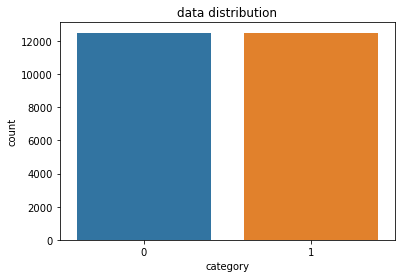

In [19]:
sns.countplot(x='category',data=df).set_title('data distribution')

## 이미지 한번 추출해보기

In [20]:
os.chdir('temp/train')

In [21]:
pwd

'D:\\jupy\\211024 cat_vs_dog\\temp\\train'

In [22]:
img = load_img(df['filename'].iloc[0])

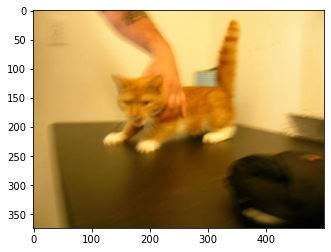

In [23]:
plt.imshow(img)

In [24]:
# train test split 
train_df, valid_df = train_test_split(df, test_size=0.25)

In [25]:
train_df.shape, valid_df.shape

((18750, 2), (6250, 2))

In [26]:
train_df.head()

,filename,category
7909,cat.5867.jpg,0
24447,dog.9500.jpg,1
500,cat.10447.jpg,0
7178,cat.5208.jpg,0
6592,cat.4681.jpg,0


In [27]:
valid_df

,filename,category
18798,dog.4416.jpg,1
12149,cat.9683.jpg,0
11196,cat.8825.jpg,0
21570,dog.6911.jpg,1
11064,cat.8706.jpg,0
...,...,...
6395,cat.4503.jpg,0
6234,cat.4359.jpg,0
14334,dog.11648.jpg,1
4963,cat.3214.jpg,0


In [28]:
# 배치파일 생성하기

def generate_train_batch(model):
    
    if model == 'resnet':
        print('resnet data')
        train_datagen = ImageDataGenerator(
            rotation_range=10, 
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            width_shift_range=0.1,
            height_shift_range=0.1,
            preprocessing_function = preprocess_input
        )
    else:
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            rescale=1./255,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            width_shift_range=0.1,
            height_shift_range=0.1)
        
        
    if model == 'vgg':
        print('vgg data')
        train_gen = train_datagen.flow_from_dataframe(
            train_df[['filename']],
            x_col = 'filename',
            y_col = None,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False
        )
    else:
        train_gen = train_datagen.flow_from_dataframe(
            train_df,
            x_col='filename',
            y_col='category',
            target_size=(img_size, img_size), 
            batch_size=batch_size,
            class_mode='binary'
        )
    return train_gen

In [29]:
def generate_valid_batch(model):
    if model == 'resnet':
        print('resnet validation set')
        valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
    
    valid_gen = valid_datagen.flow_from_dataframe(
        valid_df,
        x_col = 'filename',
        y_col = 'category',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode = 'binary'
    )
    return valid_gen

In [30]:
train_gen = generate_train_batch('others')

Found 18750 validated image filenames belonging to 2 classes.


In [31]:
valid_gen = generate_valid_batch('others')

Found 6250 validated image filenames belonging to 2 classes.


## 데이터 증강하고 증강한거 보기

In [32]:
visual_datagen = ImageDataGenerator(rotation_range=10,
                                   rescale=1./255,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [33]:
visualize_df = train_df.sample(n=1).reset_index(drop=True)

In [34]:
visualize_df

,filename,category
0,cat.7812.jpg,0


In [35]:
visualization_generator = visual_datagen.flow_from_dataframe(visualize_df,
                                                            x_col='filename',
                                                            y_col='category')

Found 1 validated image filenames belonging to 1 classes.


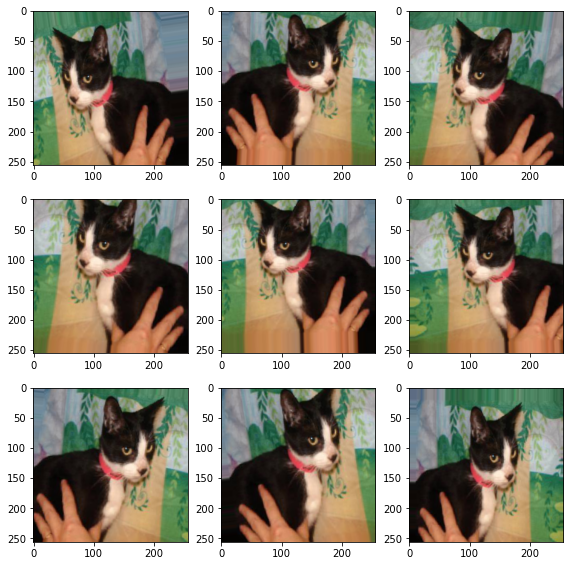

In [36]:
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    for x_batch, y_batch in visualization_generator:
        image = x_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## CNN 모델 만들기

In [37]:
from keras.applications import VGG16, resnet 
from keras.layers import *
from keras.models import Model, Sequential 
from keras import optimizers 
from keras import regularizers

In [38]:
from keras import backend as K
K.clear_session()

## 모델만들기

In [39]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu',input_shape=(img_size, img_size, 3)))
model.add(Conv2D(16,(3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1

## 학습+ 증강

In [41]:
model.fit_generator(train_gen, epochs=epochs, validation_data=valid_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
1172/1172 [==============================] - 1178s 1s/step - loss: 0.6646 - accuracy: 0.5814 - val_loss: 0.6310 - val_accuracy: 0.6373
Epoch 2/5
1172/1172 [==============================] - 872s 744ms/step - loss: 0.6019 - accuracy: 0.6726 - val_loss: 0.5677 - val_accuracy: 0.6971
Epoch 3/5
1172/1172 [==============================] - 817s 697ms/step - loss: 0.5687 - accuracy: 0.7009 - val_loss: 0.5366 - val_accuracy: 0.7251
Epoch 4/5
1172/1172 [==============================] - 818s 698ms/step - loss: 0.5430 - accuracy: 0.7221 - val_loss: 0.5021 - val_accuracy: 0.7458
Epoch 5/5
1172/1172 [==============================] - 793s 676ms/step - loss: 0.5187 - accuracy: 0.7450 - val_loss: 0.4824 - val_accuracy: 0.7590


In [42]:
loss,accuracy = model.evaluate_generator(valid_gen, valid_gen.samples//batch_size,
                                        workers=12)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [43]:
loss, accuracy = model.evaluate(train_gen, workers=12)

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

In [44]:
model.save_weights("model211030.h5")

## virtualize Training